# Question 2 a

In [3]:
#Load needed libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import cv2
from PIL import Image
import torch.optim as optim
from os import listdir,makedirs
from os.path import isfile,join


#import Matplotlib library (visualizations )
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
path = 'drive\\MyDrive\\MVmid\\'

In [18]:
#Set the input and output directories for the images
input_dir1 = '//content/drive/MyDrive/MVmid/test/Covid'
output_dir1 = '//content/drive/MyDrive/MVmid/testGray/Covid'
input_dir2 = '//content/drive/MyDrive/MVmid/test/imageNormal1'
output_dir2 = '//content/drive/MyDrive/MVmid/testGray/imageNormal1'
input_dir3 = '//content/drive/MyDrive/MVmid/test/Pneumonia'
output_dir3 ='//content/drive/MyDrive/MVmid/testGray/Pneumonia'

input_dir4 = '//content/drive/MyDrive/MVmid/train1/Covid'
output_dir4 = '//content/drive/MyDrive/MVmid/trainGray/Covid'
input_dir5 = '//content/drive/MyDrive/MVmid/train1/imageNormal1'
output_dir5 = '//content/drive/MyDrive/MVmid/trainGray/imageNormal1'
input_dir6 = '//content/drive/MyDrive/MVmid/train1/Pneumonia'
output_dir6 = '//content/drive/MyDrive/MVmid/trainGray/Pneumonia'


In [6]:

#The code transforms grayscale images to RGB format, resizes them to 150x150 pixels, and utilizes a transformer object for various operations,such as random horizontal flipping, converting images to tensors, and normalization.
#Data loaders for training and testing are created, and a ConvNet class is defined for a convolutional neural network (CNN) model.
#This model can be trained on the transformed images and used for making predictions.

In [19]:
# Define a function to convert grayscale images to RGB
def convert_rgb_to_grayscale(input_dir, output_dir):
    # Loop over the files in the input directory
    for filename in os.listdir(input_dir):
        # Load the grayscale image
        gray_image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)

        # Save the grayscale image
        cv2.imwrite(os.path.join(output_dir, filename), gray_image)




# Convert the images in each directory
convert_rgb_to_grayscale(input_dir1, output_dir1)
convert_rgb_to_grayscale(input_dir2, output_dir2)
convert_rgb_to_grayscale(input_dir3, output_dir3)
convert_rgb_to_grayscale(input_dir4, output_dir4)
convert_rgb_to_grayscale(input_dir5, output_dir5)
convert_rgb_to_grayscale(input_dir6, output_dir6)


In [20]:
#First resize all images to 32 height and width.
#Transforms

transformer = transforms.Compose(
    [ transforms.Resize((32,32)),

     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
     transforms.Grayscale(num_output_channels=1)])

batch_size = 32

In [22]:
#Dataloader
#Path for training and testing directory

train_path= '//content/drive/MyDrive/MVmid/trainGray'
test_path= '//content/drive/MyDrive/MVmid/testGray'

trainloader=DataLoader(

    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True

)

testloader=DataLoader(

    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True

)

#categories
root=pathlib.Path(train_path)
classes=sorted ([j.name.split('/')[-1] for j in root.iterdir()])

print(classes)


train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

['Covid', 'Pneumonia', 'imageNormal1']
251
66


In [23]:
#1. DEFINE THE CNN
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [24]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [25]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')

    return model, history

In [26]:
# 4. Train the model for 10 epochs

num_epochs = 25
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/25
Epoch : 000, Training: Loss: 2.2955, Accuracy: 27.0916%, 
		Validation : Loss : 2.2748, Accuracy: 30.3030%, Time: 12.3647s
Epoch: 2/25
Epoch : 001, Training: Loss: 2.2526, Accuracy: 27.8884%, 
		Validation : Loss : 2.2194, Accuracy: 31.8182%, Time: 10.1055s
Epoch: 3/25
Epoch : 002, Training: Loss: 2.1873, Accuracy: 42.6295%, 
		Validation : Loss : 2.1487, Accuracy: 56.0606%, Time: 11.6144s
Epoch: 4/25
Epoch : 003, Training: Loss: 2.1052, Accuracy: 55.3785%, 
		Validation : Loss : 2.0568, Accuracy: 39.3939%, Time: 11.9255s
Epoch: 5/25
Epoch : 004, Training: Loss: 1.9931, Accuracy: 44.2231%, 
		Validation : Loss : 1.9307, Accuracy: 39.3939%, Time: 11.7438s
Epoch: 6/25
Epoch : 005, Training: Loss: 1.8374, Accuracy: 44.2231%, 
		Validation : Loss : 1.7526, Accuracy: 39.3939%, Time: 9.9117s
Epoch: 7/25
Epoch : 006, Training: Loss: 1.6218, Accuracy: 44.2231%, 
		Validation : Loss : 1.5254, Accuracy: 39.3939%, Time: 11.7951s
Epoch: 8/25
Epoch : 007, Training: Loss: 1.3867, Accurac

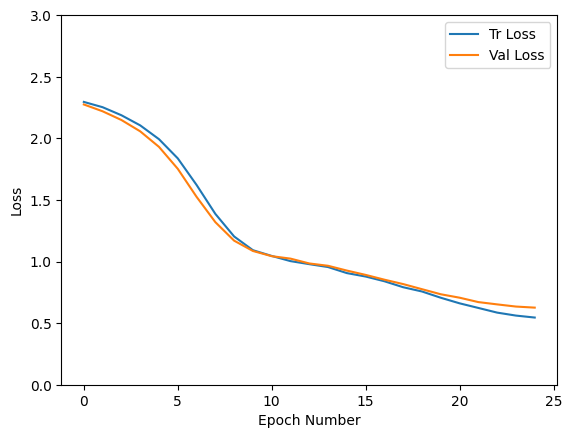

In [27]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

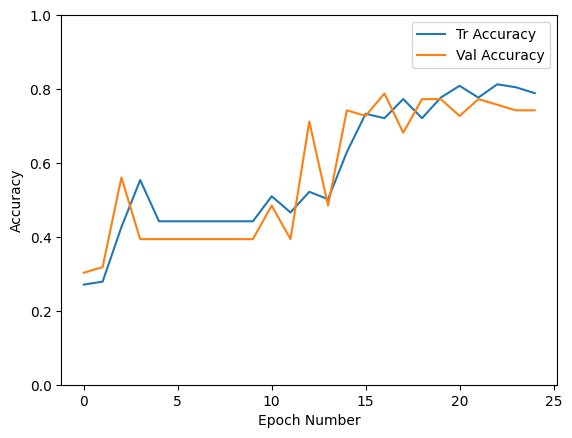

In [28]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Covid is 76.9 %
Accuracy for class: Pneumonia is 65.0 %
Accuracy for class: imageNormal1 is 80.0 %


<Axes: >

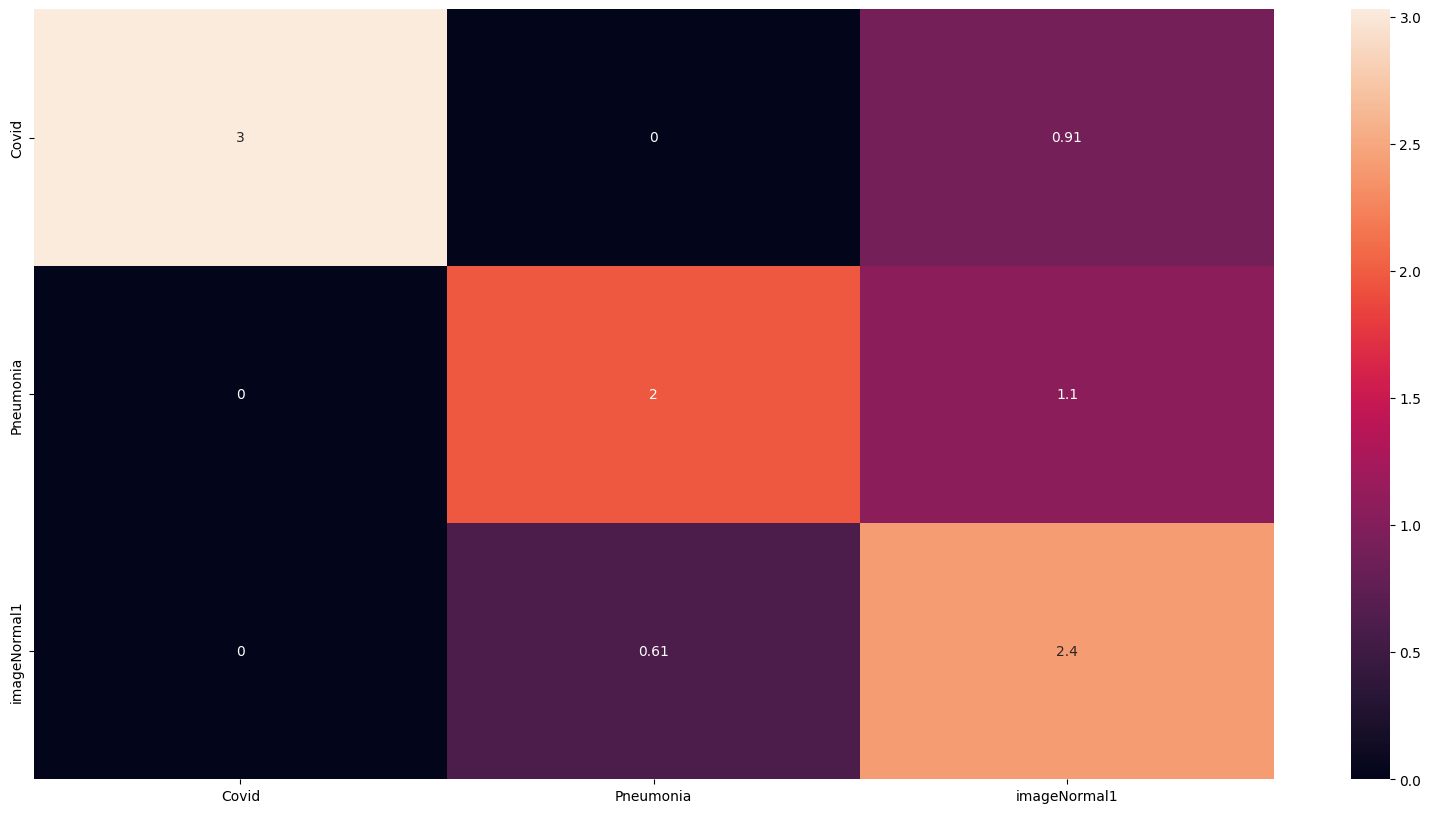

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')